In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def random_forest_model(csv_file, target_column='quality', scale=False):
    # Load the CSV
    data = pd.read_csv(csv_file, sep=',')

    # Binary classification: 0 = low (quality < 7), 1 = high (quality >= 7)
    def categorize_quality(value):
        return 1 if value >= 7 else 0

    y = data[target_column].apply(categorize_quality)

    # Separate features
    X = data.drop(target_column, axis=1)
    column_names = X.columns

    # Optional feature scaling
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.show()

    # Feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=column_names[indices])
    plt.title('Feature Importance')
    plt.show()

    return {
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": cm
    }



Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       238
           1       0.74      0.41      0.53        34

    accuracy                           0.91       272
   macro avg       0.83      0.70      0.74       272
weighted avg       0.90      0.91      0.90       272

Confusion Matrix:
 [[233   5]
 [ 20  14]]


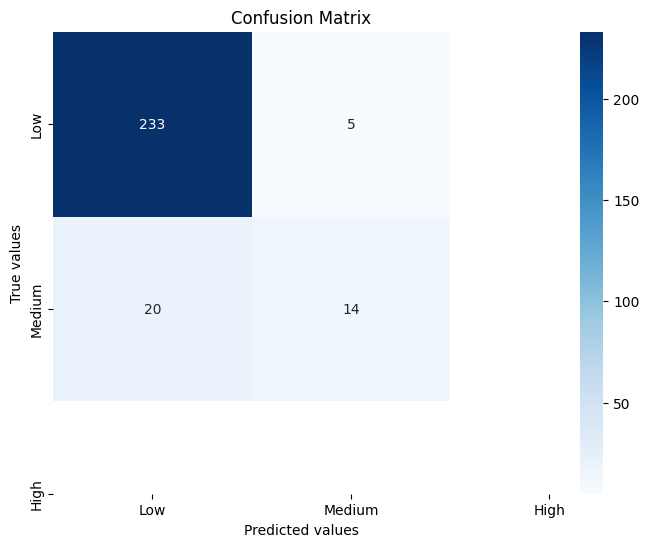

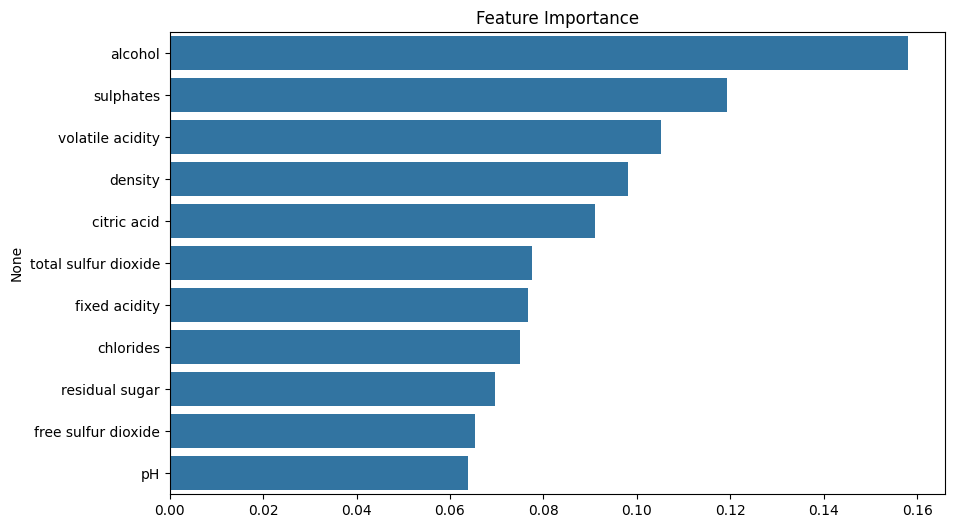

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88       618
           1       0.63      0.30      0.41       175

    accuracy                           0.81       793
   macro avg       0.73      0.63      0.65       793
weighted avg       0.78      0.81      0.78       793

Confusion Matrix:
 [[587  31]
 [122  53]]


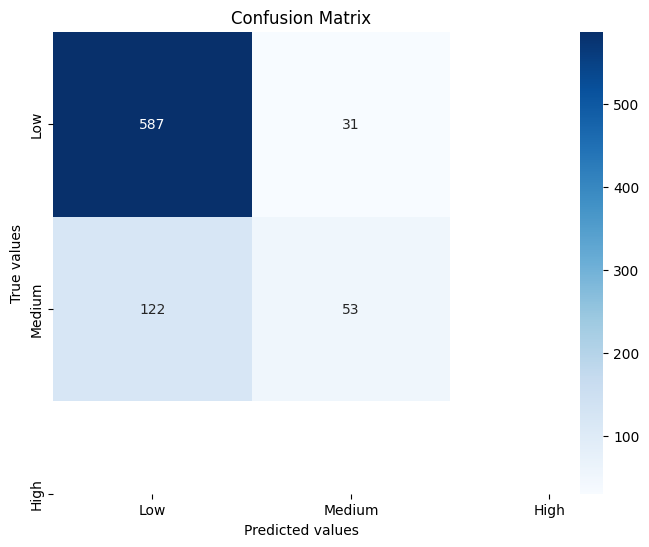

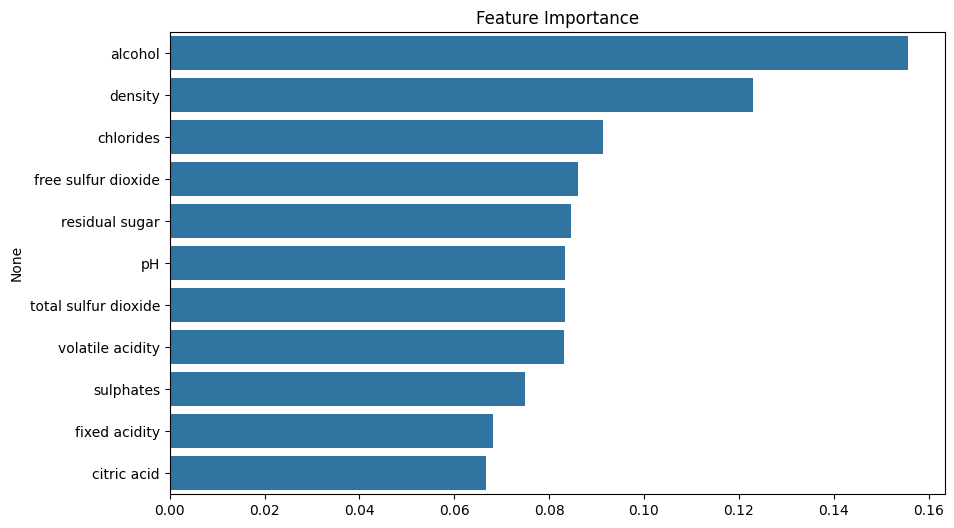

In [2]:
metrics = random_forest_model("../cleanDatasets/winequality-red_cleaned.csv", target_column="quality", scale=True)

metrics = random_forest_model("../cleanDatasets/winequality-white_cleaned.csv", target_column="quality", scale=True)